# Tutorial 5 - Projection of 2D FES to 1D FEP with error propagation

## Introduction

This notebook illustrates the application of ThermoLIB to project a 2D FES into a 1D FEP along a direction of choice, with proper propagation of error bars.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import FreeEnergySurface2D, SimpleFreeEnergyProfile
from thermolib.thermodynamics.histogram import Histogram2D
from thermolib.tools import read_wham_input, decorrelate
from thermolib.thermodynamics.trajectory import ColVarReader

import numpy as np, matplotlib.pyplot as pp, time

from molmod.units import *

Define some file/path variables

In [3]:
prefix = 'basic_wham2d_' #will be added to all figures made in this notebook
fn_meta = 'data/HZSM5_link/wham_input_2D.txt' #location of the plumed metadata file containing all information of the umbrella sampling

## Constructing 2D FES

We first construct the 2D FES with error bars using the `mle_f_cov` method as was illustrated in other tutorials. We stress that estimation of the covariance is crucial to have proper error propagation after projection.

In [4]:
colvar_reader = ColVarReader([1,2], units=['au','au'])
temp, biasses, trajectories = read_wham_input(
    fn_meta, colvar_reader, 'colvars/colvar_%s.dat', 
    bias_potential='Parabola2D', q01_unit='au', q02_unit='au', kappa1_unit='kjmol', kappa2_unit='kjmol',
)

In [5]:
bins = [np.arange(1,4.025,0.025), np.arange(-2.5,0.025,0.025)]
hist = Histogram2D.from_wham(bins, trajectories, biasses, temp, Nscf=10000)

  SCF Converged!

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.024s
  bias poten. : 00h 00m 02.167s
  solve scf   : 00h 00m 01.009s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 03.201s
---------------------------------------------------------------------


/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1600: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = pp.colorbar(contourf, ax=ax, extend='both')


<Figure size 432x288 with 0 Axes>

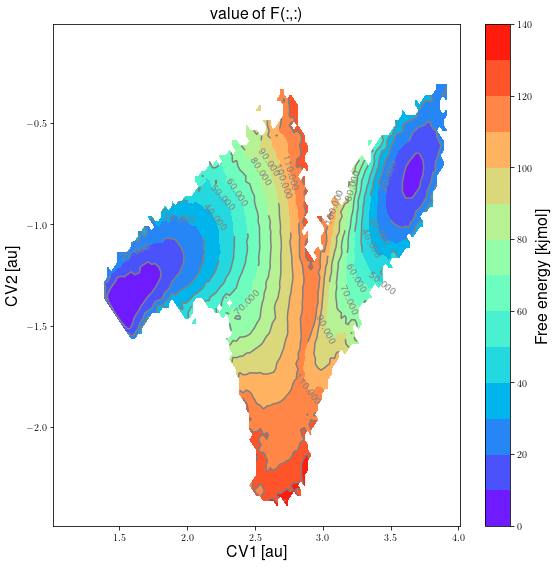

In [6]:
fes = FreeEnergySurface2D.from_histogram(hist, temp)
fes.set_ref(ref='min')
fes.plot(cmap='rainbow', flims=[0,140], ncolors=14)

## Projection onto 1D profile

The 2D FES can be projected onto any new collective variable $Q$ that is a function of the 2 original collective variables $CV_1$ and $CV_2$. However, some typical directions are predefined in ThermoLIB, such as projecting onto $CV_1$ (i.e. $Q=CV_1$), onto $CV_2$ ($Q=CV_2$), onto the difference ($Q=CV_2-CV_1$) or the average ($Q=0.5\cdot(CV_1+CV_2)$).

### Along predefined direction

We first illustrate how to project onto $CV_1$.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


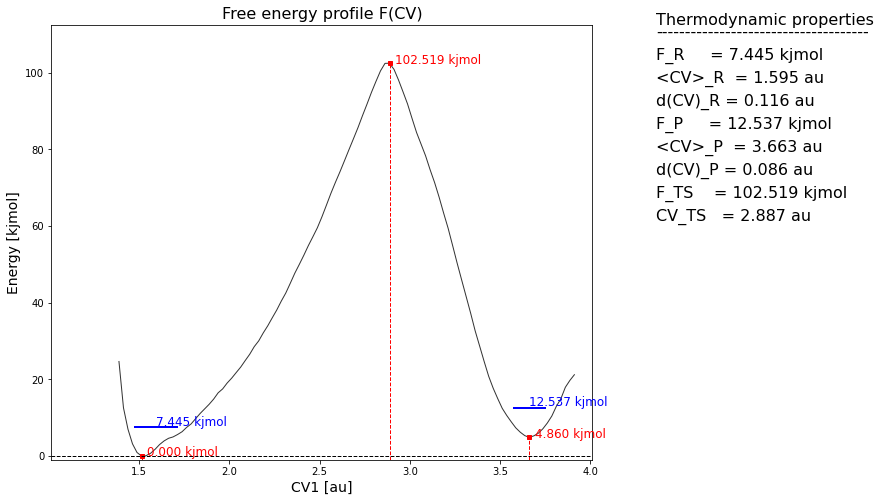

In [7]:
fep_cv1 = fes.project_cv1(return_class=SimpleFreeEnergyProfile)
fep_cv1.process_states(lims=[-np.inf,2.4,3.0,np.inf])
fep_cv1.set_ref(ref='r')
fep_cv1.plot()

### Along any custom direction

The above projection used a predefined direction of projection, i.e. onto CV1. However, we can define and perform a projection onto any preferred direction using the ``project_function`` routine of the ``FreeEnergySurface2D`` class. We will now illustrate this for a an exotic choice of the collective variable to project onto:

$f(CV_1,CV_2) = \sqrt{(CV1-1.6)^2 + (CV2+1.4)^2} - \sqrt{(CV1-3.6)^2 + (CV2+0.8)^2}$

which could be interpreted as the difference in 'distance' between the reactant and product state. We first define this function as a python routine:

In [8]:
def function(cv1,cv2):
    dR = np.sqrt((cv1-1.6)**2 + (cv2+1.2)**2)
    dP = np.sqrt((cv1-3.6)**2 + (cv2+0.8)**2)
    return dR-dP

You can always visualize the projection direction by plotting the contours of the chosen function $f(CV_1,CV_2)$ on top of the 2D FES using the ``plot_additional_function_contours`` keyword of the ``plot`` routine:

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1600: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = pp.colorbar(contourf, ax=ax, extend='both')
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1607: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour = ax.contour(xs, ys, fvals, colors='red', linewidth=2.0)


<Figure size 432x288 with 0 Axes>

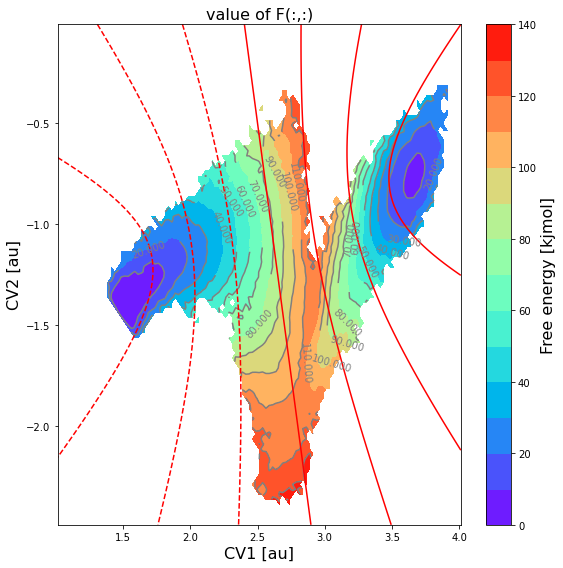

In [9]:
fes.plot(plot_additional_function_contours=[function, [-2.0, -1.5, -0.5, 0, 0.5, 1.5, 2.0]], flims=[0,140], ncolors=14, cmap='rainbow')

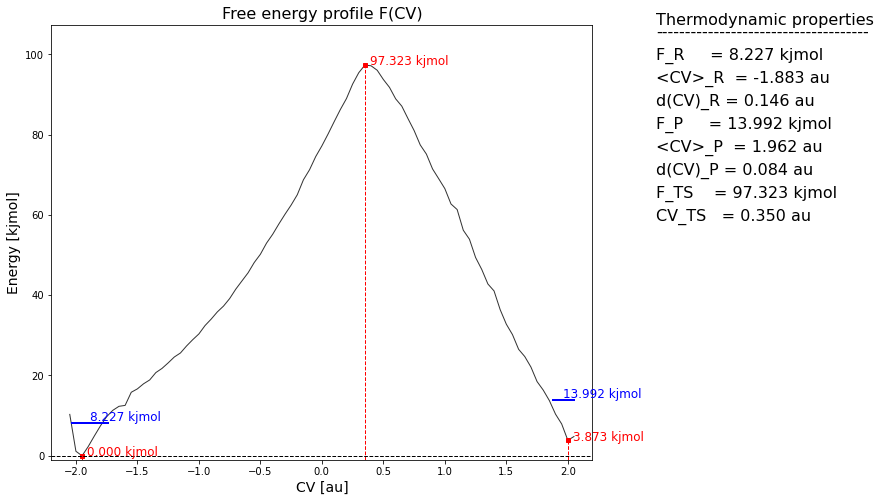

In [10]:
fep_fun = fes.project_function(function, np.arange(-2.20,2.25,0.05), delta=0.05, return_class=SimpleFreeEnergyProfile)
fep_fun.process_states(lims=[-np.inf,0.0,1.0,np.inf])
fep_fun.set_ref(ref='r')
fep_fun.plot()

## Error propagation

We can now redo the above procedure of construction of the 2D FES and projection onto CV1 including and ``mle_f_cov`` error estimation. However, in order to get adequate error estimates, we first estimate the correlation times.

/home/louis/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 432x288 with 0 Axes>

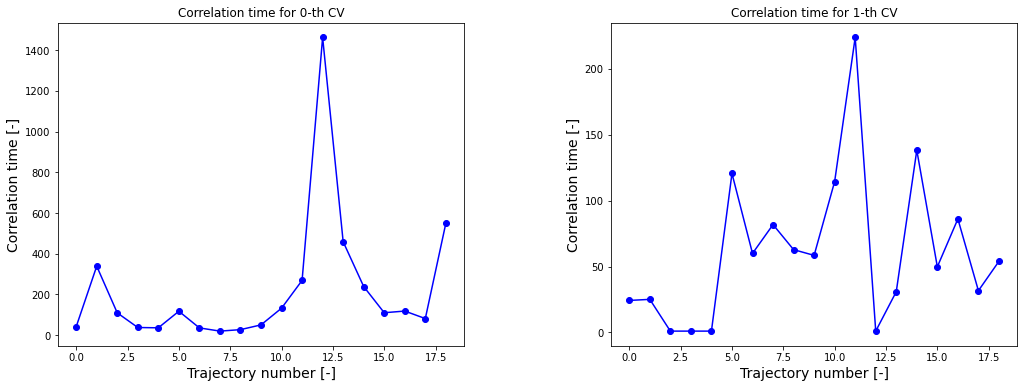

In [11]:
corrtimes = decorrelate(trajectories, plot=True)

We now construct the 2D FES with error.

In [12]:
bins = [np.arange(1,4.025,0.025), np.arange(-2.5,0.025,0.025)]
hist_err = Histogram2D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)
fes_err = FreeEnergySurface2D.from_histogram(hist_err, temp)
fes_err.set_ref(ref='min')

  SCF Converged!

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.025s
  bias poten. : 00h 00m 02.094s
  solve scf   : 00h 00m 00.857s
  error est.  : 00h 00m 11.263s
  TOTAL       : 00h 00m 14.241s
---------------------------------------------------------------------


/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1600: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = pp.colorbar(contourf, ax=ax, extend='both')


<Figure size 432x288 with 0 Axes>

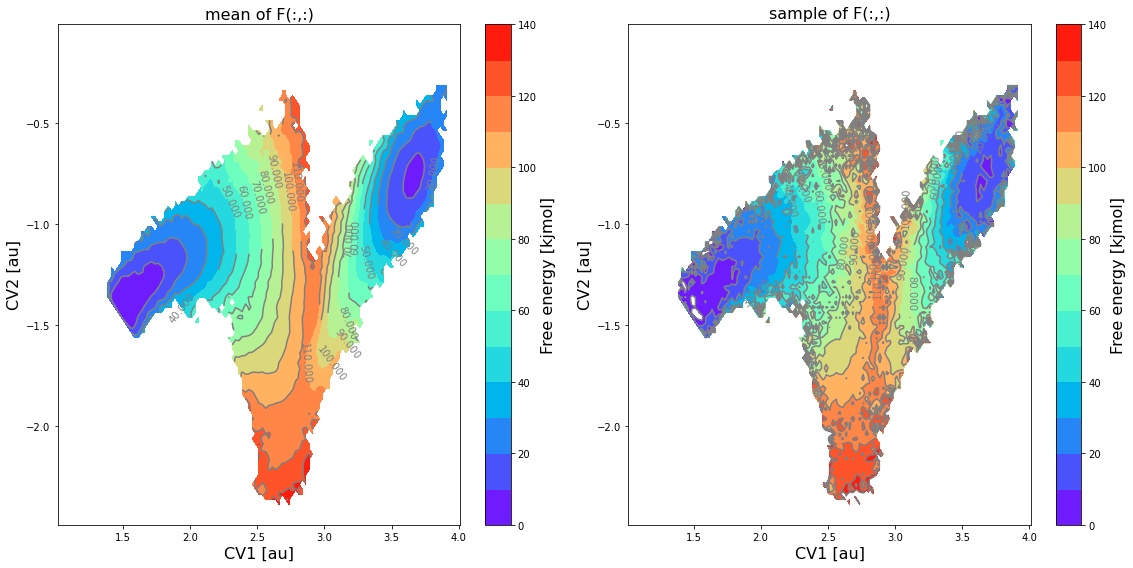

<Figure size 432x288 with 0 Axes>

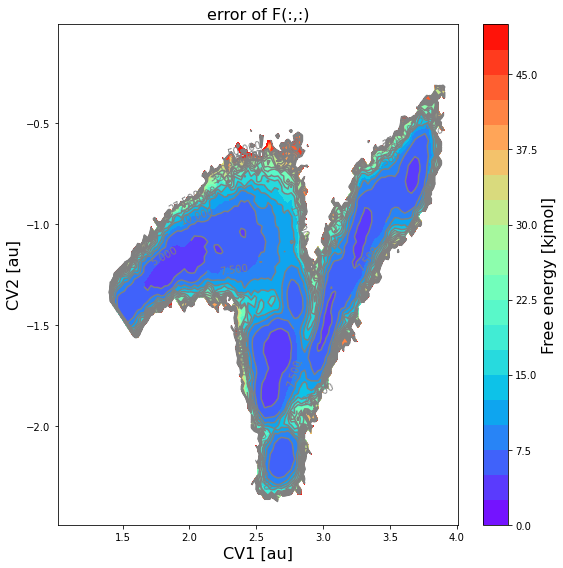

In [13]:
fes_err.plot(obss=['mean', 'sample'], flims=[0,140], ncolors=14, cmap='rainbow')
fes_err.plot(obss=['error'], flims=[0,50], ncolors=20, cmap='rainbow')

We can again project the FES. However, as the error is now included, it will not just project the mean profile. Instead, it will generate a number of random samples (50 by default) from the error distribution, project each of those samples and compute the mean and error from those.

In [14]:
fep_cv1_err = fes_err.project_cv1(return_class=SimpleFreeEnergyProfile)
fep_cv1_err.process_states(lims=[-np.inf,2.6,3.0,np.inf])
fep_cv1_err.set_ref(ref='r')

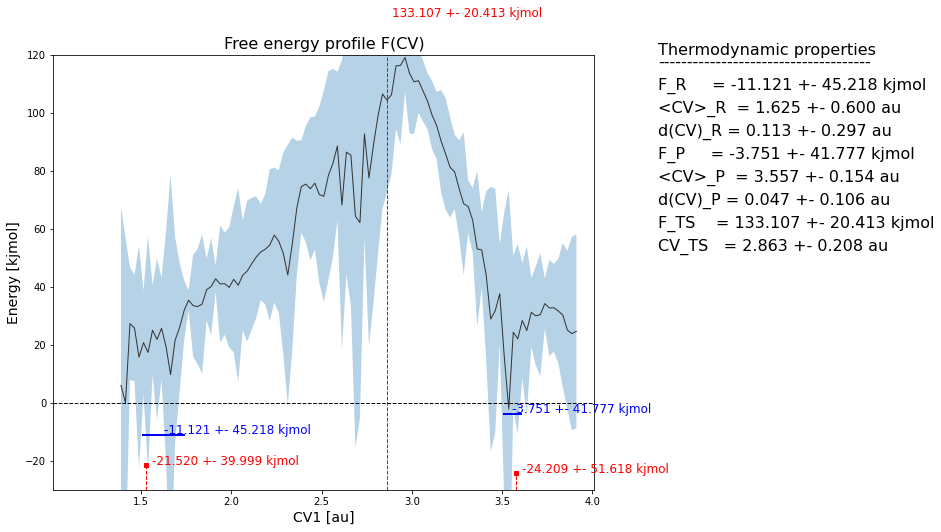

In [15]:
fep_cv1_err.plot(flims=[-30,120])

We see large error bars on the projected free energy profile. This is due to the fact that the original free energy surface has large error bars on the edge of the sampled region, which is due to limited sampling occuring there. These large error bars are then propagated through the projection and result in high error bars in the projected FEP. This is unavoidable, as there will alsways be an 'edge region' which has large errors. Therefore, to work around this issue, we can avoid estimating error bars for those regions that were insufficiently sampled (with a user defined thresshold) and therefore not account for those in error propagation. How to do this is illustrated in the next section.

### Deal with the unsufficiently sampled edges of phase space in FES projection

In order to avoid estimating error bars for regions that were insufficiently sampled (for reasons outlined at the end of previous section), we specify an additional parameter, `error_p_threshold` in the ``from_wham`` routine. This means that a certain bin is deactivated (i.e. excluded from histogram construction) if there is not a single simulation for which the (biased) probability in that bin is above the thresshold. In other words, setting `error_p_threshold=0.0005` means that any bin in the FES for which there is no single biased simulation in which the biased probability is greater than 0.0005, will be deactivated for error estimation (i.e. its error will not be computed leading to a blank spot in the contour plots of the error and derived properties such as lower, upper and sample).

In [16]:
bins = [np.arange(1,4.025,0.025), np.arange(-2.5,0.025,0.025)]
hist_err2 = Histogram2D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000, error_p_threshold=0.0005)
fes_err2 = FreeEnergySurface2D.from_histogram(hist_err2, temp)
fes_err2.set_ref(ref='min')

  SCF Converged!

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.024s
  bias poten. : 00h 00m 02.158s
  solve scf   : 00h 00m 00.875s
  error est.  : 00h 00m 12.761s
  TOTAL       : 00h 00m 15.819s
---------------------------------------------------------------------


/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1600: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = pp.colorbar(contourf, ax=ax, extend='both')


<Figure size 432x288 with 0 Axes>

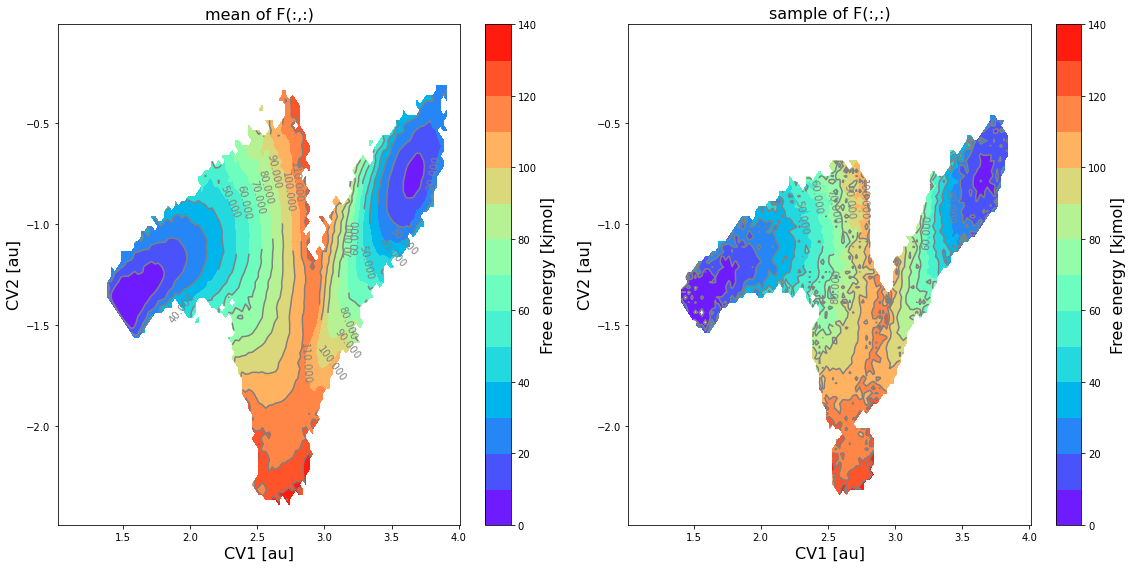

<Figure size 432x288 with 0 Axes>

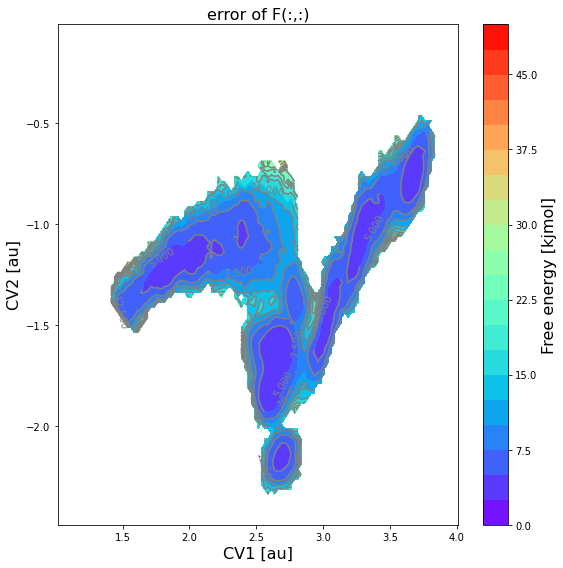

In [17]:
fes_err2.plot(obss=['mean', 'sample'], flims=[0,140], ncolors=14, cmap='rainbow')
fes_err2.plot(obss=['error'], flims=[0,50], ncolors=20, cmap='rainbow')


The mean profile itself has not changed (unaffected by setting error_p_threshold), but it is clear that the phase space with error bars has been decreased, which in turn also results in a smaller phase space for samples taken from the error distribution.

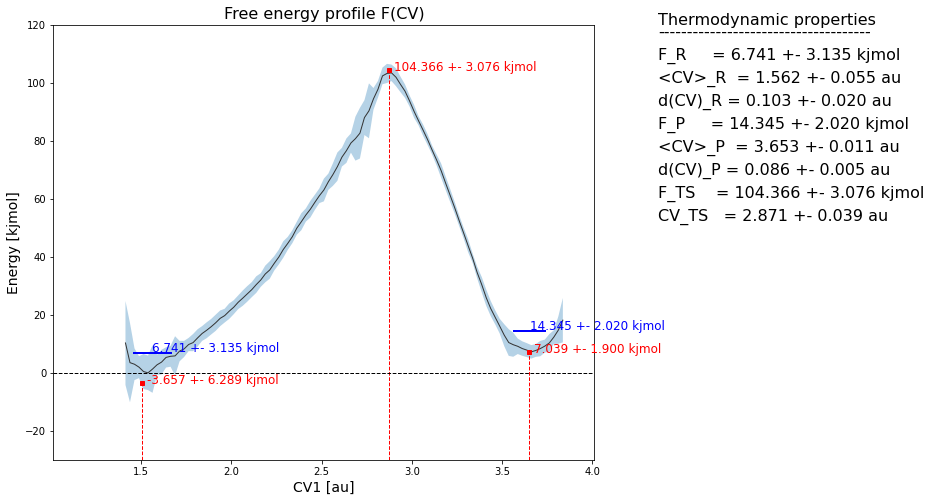

In [18]:
fep_cv1_err2 = fes_err2.project_cv1(return_class=SimpleFreeEnergyProfile)
fep_cv1_err2.process_states(lims=[-np.inf,2.6,3.0,np.inf])
fep_cv1_err2.set_ref(ref='r')
fep_cv1_err2.plot(flims=[-30,120])

We indeed see that the errors have significantly decreased. In order to know what value to choose for error_p_threshold, our advice would be to do some trial-and-error. Tune it untill the region in phase space excluded from error estimation is what you want it to be.